In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:

class NeuralNetwork3:

    def __init__(self, layer_sizes, activation='sigmoid', output_activation='linear', init_method='normal',bias_sd = 0.01):
        """
        Inicjalizuje sieć neuronową MLP.

        :param layer_sizes: Lista określająca liczbę neuronów w kolejnych warstwach, np. [1, 5, 1]
        :param activation: Funkcja aktywacji dla warstw ukrytych (domyślnie 'sigmoid')
        :param output_activation: Funkcja aktywacji dla warstwy wyjściowej (domyślnie 'linear')
        :param init_method: Metoda inicjalizacji wag, opcje:
                            'normal'  - N(0,1) (domyślnie),
                            'uniform' - U[0,1],
                            'he'      - inicjalizacja He,
                            'xavier'  - inicjalizacja Xavier.
                            W przypadku nieznanej metody używana jest inicjalizacja normalna.
        """
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.init_method = init_method
        self.gradient_history = []

        # Inicjalizacja parametrów (wag i biasów) dla każdej warstwy poza wejściową
        self.params = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]

            if init_method == 'normal':
                # Domyślna inicjalizacja: N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'uniform':
                # Inicjalizacja z U[0,1]
                W = np.random.rand(n_out, n_in)
                b = np.random.rand(n_out, 1) * bias_sd
            elif init_method == 'he':
                # Inicjalizacja He: dla warstw z ReLU lub jej wariantami
                W = np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'xavier':
                # Inicjalizacja Xavier: dla warstw z sigmoid lub tanh
                W   = np.random.randn(n_out, n_in) * np.sqrt(1 / (n_in + n_out))
                b = np.random.randn(n_out, 1) * bias_sd
            else:
                # W przypadku nieznanej metody używamy domyślnej inicjalizacji N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd

            self.params.append({'W': W, 'b': b})

    def sigmoid(self, z):
        """
        Funkcja aktywacji sigmoidalnej z ograniczeniem zakresu dla stabilności numerycznej.
        """
        z = np.clip(z, -15, 15)
        return 1.0 / (1.0 + np.exp(-z))

    def relu(self, z):
        """
        Funkcja aktywacji ReLU
        """
        return np.maximum(0, z)



    def linear(self, z):
        """
        Funkcja aktywacji liniowej.
        """
        return z

    def forward(self, X):
        """
        Przeprowadza propagację w przód.

        :param X: Dane wejściowe w postaci macierzy [D x N] (D - cechy, N - liczba próbek)
        :return: Wynik propagacji (output sieci)
        """
        # Propagacja przez warstwy ukryte

        activation_func = getattr(self, self.activation)
        for i in range(len(self.layer_sizes) - 2):
            X = activation_func(self.params[i]['W'] @ X + self.params[i]['b'])

        # Warstwa wyjściowa z określoną funkcją aktywacji
        output_func = getattr(self, self.output_activation)
        return output_func(self.params[-1]['W'] @ X + self.params[-1]['b'])

    def compute_loss(self, y_true, y_pred):
        """
        Oblicza funkcję kosztu (MSE).

        MSE = (1/N) * sum((y_pred - y_true)^2)
        """
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        N = y_true.shape[0]
        return (1 / N) * np.sum((y_pred - y_true) ** 2)


    def calculate_gradient(self, x_batch, y_batch, clip_threshold=1.0):
        """
        Oblicza gradienty wag i biasów metodą backpropagation z gradient clipping.

        :param x_batch: Dane wejściowe dla batcha w postaci macierzy [D x N],
                        gdzie D - liczba cech, N - liczba próbek.
        :param y_batch: Odpowiedzi dla batcha (wektor lub macierz [output_size x N])
        :param clip_threshold: Próg normy, powyżej którego gradienty są skalowane.
        :return: Lista gradientów dla poszczególnych warstw,
                 gdzie każdy element to słownik {'W': gradient_wag, 'b': gradient_biasów}
        """

        # Forward pass – zapisujemy aktywacje i wartości przed funkcją aktywacji (pre-activations)
        activations = [x_batch]  # a^(0) = x_batch
        zs = []                # lista przechowująca z = W*a + b dla każdej warstwy
        for i in range(len(self.params)):
            z = self.params[i]['W'] @ activations[-1] + self.params[i]['b']
            zs.append(z)
            # Dla warstw ukrytych używamy funkcji określonej przez self.activation,
            # a dla warstwy wyjściowej funkcji self.output_activation
            if i < len(self.params) - 1:
                a = getattr(self, self.activation)(z)
            else:
                a = getattr(self, self.output_activation)(z)
            activations.append(a)

        # Upewnij się, że y_batch ma taki sam kształt jak output sieci
        if y_batch.ndim == 1:
            y_batch = y_batch.reshape(activations[-1].shape)

        m = x_batch.shape[1]  # liczba próbek w batchu

        # Obliczenie początkowego delta na podstawie MSE, pochodna z mse po aktywacji
        delta = (2.0 / m) * (activations[-1] - y_batch)

        # Modyfikacja delta przez pochodną funkcji aktywacji warstwy wyjściowej
        # domnazamy pochodna z po aktywacji
        if self.output_activation == 'linear':
            pass  # dla liniowej pochodna = 1, czyli bez zmian
        elif self.output_activation == 'sigmoid':
            delta = delta * (activations[-1] * (1 - activations[-1]))
        elif self.output_activation == 'relu':
            delta = delta * (zs[-1] > 0).astype(float)
        else:
            pass  # domyślnie pozostawiamy bez zmian



        # Obliczenie gradientów dla warstwy wyjściowej
        gradients = [None] * len(self.params)
        dW = delta @ activations[-2].T
        db = np.sum(delta, axis=1, keepdims=True)
        gradients[-1] = {'W': dW, 'b': db}

        # Backpropagation przez warstwy ukryte
        for i in range(len(self.params) - 2, -1, -1):
            delta = self.params[i+1]['W'].T @ delta
            if self.activation == 'sigmoid':
                delta = delta * (activations[i+1] * (1 - activations[i+1]))
            elif self.activation == 'relu':
                delta = delta * (zs[i] > 0).astype(float)
            else:
                pass  # dla liniowych funkcji aktywacji nie zmieniamy delta
            dW = delta @ activations[i].T
            db = np.sum(delta, axis=1, keepdims=True)
            gradients[i] = {'W': dW, 'b': db}

        # Gradient clipping – skalujemy każdy gradient jeśli jego norma przekracza clip_threshold
        # maksymalna norma layera czy to biasu czy wag ma byc 1
        for layer_grad in gradients:
            for key in layer_grad:
                grad_norm = np.linalg.norm(layer_grad[key])
                if grad_norm > clip_threshold:
                    layer_grad[key] = layer_grad[key] * (clip_threshold / grad_norm)

        return gradients



    def vector_to_gradients(self, grad_vector):
        """
        Odwraca funkcję gradients_to_vector.
        Na podstawie wektora grad_vector oraz oryginalnych kształtów parametrów,
        zwraca listę słowników gradientów w tej samej strukturze, co w self.params.

        :param grad_vector: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        :return: Lista słowników gradientów, gdzie każdy słownik ma klucze 'W' oraz 'b'
                 z gradientami o odpowiednich kształtach.
        """
        gradients = []
        current_index = 0

        # Iterujemy przez warstwy korzystając z kształtów parametrów zapisanych w self.params
        for layer in self.params:
            layer_grad = {}

            # Kształt i liczba elementów gradientu dla wag (W)
            W_shape = layer['W'].shape
            W_size = np.prod(W_shape)
            # Wydzielamy fragment wektora dla wag i przekształcamy go do odpowiedniego kształtu
            W_grad = grad_vector[current_index: current_index + W_size].reshape(W_shape)
            current_index += W_size

            # Kształt i liczba elementów gradientu dla biasów (b)
            b_shape = layer['b'].shape
            b_size = np.prod(b_shape)
            # Wydzielamy fragment wektora dla biasów i przekształcamy go do odpowiedniego kształtu
            b_grad = grad_vector[current_index: current_index + b_size].reshape(b_shape)
            current_index += b_size

            layer_grad['W'] = W_grad
            layer_grad['b'] = b_grad

            gradients.append(layer_grad)

        return gradients


    def gradients_to_vector(self,gradients):
        """
        Zamienia listę słowników gradientów na jeden wektor.

        :param gradients: Lista słowników gradientów,
                          gdzie każdy słownik ma klucze 'W' (gradient wag)
                          oraz 'b' (gradient biasów).
        :return: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        """
        grad_vector = []
        for layer_grad in gradients:
            # Spłaszczamy gradient wag i biasów i dodajemy do listy
            grad_vector.append(layer_grad['W'].ravel())
            grad_vector.append(layer_grad['b'].ravel())
        # Łączymy wszystkie spłaszczone elementy w jeden wektor
        return np.concatenate(grad_vector)


    def train(self,
              X_train,
              y_train,
              batch_size,
              epochs,
              learning_rate=0.01,
              verbose=250,
              optimizer='basic',
              beta=0.9,
              beta_1=0.9,
              beta_2=0.999,
              eps=1e-8,
              return_losses=False):
        """
        Trenuje sieć neuronową metodą mini-batch gradient descent, wspierając
        różne optymalizatory (m.in. Adam, RMSProp).

        Parametry:
        ----------
        X_train : ndarray, shape [D, N]
            Dane treningowe, gdzie D to liczba cech, a N to liczba próbek.
        y_train : ndarray, shape [N] lub [1, N]
            Odpowiedzi (etykiety) dla próbek.
        batch_size : int
            Rozmiar mini-batcha.
        epochs : int
            Liczba epok treningowych.
        learning_rate : float
            Współczynnik uczenia (domyślnie 0.01).
        verbose : int
            Co ile epok wyświetlać informację o błędzie (domyślnie co 250).
        optimizer : {'basic', 'adam', 'RMSProp'}
            Wybór optymalizatora.
        beta : float
            Współczynnik momentum dla RMSProp (domyślnie 0.9).
        beta_1 : float
            Współczynnik momentum dla Adama (domyślnie 0.9).
        beta_2 : float
            Współczynnik dla średniej kwadratów gradientów w Adamie (domyślnie 0.999).
        eps : float
            Drobna stała zapobiegająca dzieleniu przez zero (domyślnie 1e-8).
        return_losses : bool
            Jeśli True, po zakończeniu treningu zwracana jest lista strat
            z każdej epoki (domyślnie False).

        Zwraca:
        -------
        Nic (lub listę strat, jeśli return_losses=True).
        """

        # Zmienna 't' dla Adama – zlicza łączną liczbę batchy (kroków optymalizacji).
        if optimizer == 'adam':
            t = 0

        # Przy RMSProp także potrzebujemy przechowywać stan (gradient_squared_mean),
        # ale w tej wersji kodu zainicjalizujemy go dopiero przy pierwszym batchu.
        if optimizer == 'RMSProp':
            pass

        # Lista do przechowywania strat po każdej epoce (tylko jeśli będzie potrzebna).
        epoch_losses = []

        # Liczba próbek
        num_samples = X_train.shape[1]

        # Pętla po epokach
        for epoch in range(epochs):
            # Losowa permutacja indeksów (shuffle)
            indices = np.random.permutation(num_samples)

            # Pętla po batchach
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_indices = indices[start_idx:end_idx]

                # Tworzymy batch
                X_batch = X_train[:, batch_indices]
                y_batch = y_train[batch_indices]

                # Obliczamy gradienty (backprop + ewentualny clipping)
                gradients = self.calculate_gradient(X_batch, y_batch)

                # Jeśli używamy Adama lub RMSProp, przetwarzamy te gradienty
                if optimizer in ('adam', 'RMSProp'):
                    # Inkrementacja kroków optymalizacji
                    vector_gradient = self.gradients_to_vector(gradients)

                    if optimizer == 'adam':
                        t += 1
                        # Inicjalizacja m_t i v_t w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            m_t = np.zeros_like(vector_gradient)
                            v_t = np.zeros_like(vector_gradient)
                        else:
                            # Aktualizacja pierwszego i drugiego momentu
                            m_t = beta_1 * m_t + (1 - beta_1) * vector_gradient
                            v_t = beta_2 * v_t + (1 - beta_2) * (vector_gradient ** 2)

                        # Korekta biasu (Adam)
                        m_t_hat = m_t / (1 - beta_1 ** t)
                        v_t_hat = v_t / (1 - beta_2 ** t)

                        # Obliczamy przyrost (update)
                        update = m_t_hat / (np.sqrt(v_t_hat) + eps)

                        # Zamiana wektora 'update' w strukturę gradientów
                        gradients = self.vector_to_gradients(update)

                    elif optimizer == 'RMSProp':
                        # Inicjalizacja w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            gradient_squared_mean = np.zeros_like(vector_gradient)

                        # Aktualizacja wykładniczej średniej kwadratów gradientów
                        gradient_squared_mean = beta * gradient_squared_mean + (1 - beta) * (vector_gradient ** 2)

                        # Obliczamy przyrost
                        update = vector_gradient / (np.sqrt(gradient_squared_mean) + eps)

                        # Konwersja wektora 'update' na listę gradientów
                        gradients = self.vector_to_gradients(update)

                # Aktualizacja wag i biasów w sieci
                for i in range(len(self.params)):
                    self.params[i]['W'] -= learning_rate * gradients[i]['W']
                    self.params[i]['b'] -= learning_rate * gradients[i]['b']

            # Obliczamy stratę po zakończeniu każdej epoki
            y_pred = self.forward(X_train)
            loss = self.compute_loss(y_train, y_pred)

            # Wyświetlamy, jeśli przypada kolej epoki zgodnie z verbose
            if epoch % verbose == verbose-1:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

            # Zapisujemy stratę do listy (jeśli będziemy zwracać)
            epoch_losses.append(loss)
        if(verbose > 10000):
            # Po zakończeniu wszystkich epok – obliczamy finalny błąd
            final_loss = self.compute_loss(y_train, self.forward(X_train))
            print(f"Final Loss: {final_loss}")

        # Jeśli chcemy zwrócić listę strat z każdej epoki
        if return_losses:
            return epoch_losses







In [7]:
def plot_xy_scatter(data, title='y = f(x)'):
    """
    Tworzy wykres punktowy dla danych zawierających kolumny 'x' oraz 'y'.

    Parameters:
    - data: DataFrame z kolumnami 'x' oraz 'y'
    - title: tytuł wykresu (domyślnie 'y = f(x)')
    """
    plt.figure(figsize=(6, 4))
    plt.scatter(data['x'], data['y'], s=20)  # s określa rozmiar punktów
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_results(x_test, y_test, y_pred):
    """
    Funkcja tworzy wykres punktowy porównujący
    wartości rzeczywiste (y_test) i przewidywane (y_pred)
    w zależności od x_test.
    
    Parametry:
    -----------
    x_test : array-like, shape (n_samples,)
        Jednowymiarowy wektor cechy (po skalowaniu).
    y_test : array-like, shape (n_samples,)
        Rzeczywiste wartości wyjściowe.
    y_pred : array-like, shape (n_samples,)
        Przewidywane wartości wyjściowe (po odskalowaniu).
    """

    plt.figure(figsize=(8, 5))
    
    # Wykres punktowy wartości rzeczywistych
    plt.scatter(x_test, y_test, color='blue', label='y_test')
    
    # Wykres punktowy wartości przewidywanych
    plt.scatter(x_test, y_pred, color='red', label='y_pred')
    
    plt.xlabel("x_test_scaled_2")
    plt.ylabel("Wartości y")
    plt.title("Porównanie wartości rzeczywistych i przewidywanych")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:

def load_and_scale_data(training_csv, test_csv, feature_col='x', target_col='y'):
    """
    Wczytuje dane z plików CSV oraz skaluje je (standaryzacja).

    Parametry:
      - training_csv: Ścieżka do pliku CSV z danymi treningowymi.
      - test_csv: Ścieżka do pliku CSV z danymi testowymi.
      - feature_col: Nazwa kolumny zawierającej cechy (domyślnie 'x').
      - target_col: Nazwa kolumny zawierającej etykiety (domyślnie 'y').

    Zwraca:
      - x_train_scaled: Zescalowane dane treningowe (features) [1 x N_train].
      - y_train_scaled: Zescalone etykiety treningowe.
      - x_test_scaled: Zescalowane dane testowe (features) [1 x N_test].
      - y_test: Oryginalne etykiety testowe (bez skalowania).
      - scaling_params: Krotka (x_mean, x_std, y_mean, y_std) – parametry skalowania,
                        które później można użyć do odwrotnej transformacji wyników.
    """
    # Wczytanie danych


    # Wyodrębnienie kolumn i przekształcenie do odpowiednich kształtów
    x_train = training_csv[[feature_col]].values.T
    y_train = training_csv[target_col].values

    x_test = test_csv[[feature_col]].values.T
    y_test = test_csv[target_col].values

    # Obliczanie średniej i odchylenia standardowego dla x oraz y
    x_mean = np.mean(x_train)
    x_std  = np.std(x_train)
    y_mean = np.mean(y_train)
    y_std  = np.std(y_train)

    # Skalowanie danych (standaryzacja)
    x_train_scaled = (x_train - x_mean) / x_std
    y_train_scaled = (y_train - y_mean) / y_std
    x_test_scaled  = (x_test - x_mean) / x_std

    scaling_params = (x_mean, x_std, y_mean, y_std)
    return x_train_scaled, y_train_scaled, x_test_scaled, y_test, scaling_params

In [9]:
def save_dict(neural_network, file_name="data/NN2/weights_multimodal_large.txt"):
    """
    Zapisuje parametry sieci (neural_network_2.params) do pliku w formie tekstowej.

    Parametry:
    - neural_network_2: obiekt zawierający atrybut params (np. listę słowników z 'W' i 'b').
    - nazwa_pliku (str): nazwa (lub ścieżka) pliku wyjściowego.
    """
    with open(file_name, "w", encoding="utf-8") as f:
        # Używamy repr, aby zachować formę 'array([...])', co ułatwi późniejsze wczytanie evalem.
        f.write(repr(neural_network.params))

In [10]:
def read_dict(file_name):
    """
    This function reads the contents of a text file containing a list of dictionaries.
    Each dictionary includes the keys 'W' and 'b', with their values represented as numpy arrays.

    Parameters:
        file_name (str): Path to the text file.

    Returns:
        list: A list of dictionaries with the data.
    """
    with open(file_name, 'r', encoding='utf-8') as f:
        content = f.read()

    # Using eval with restricted globals to allow only numpy.array
    data = eval(content, {"__builtins__": None}, {"array": np.array})
    return data

In [11]:
# Wczytywanie steps-large
steps_large_training = pd.read_csv("data/NN3/steps-large-training.csv")
steps_large_test     = pd.read_csv("data/NN3/steps-large-test.csv")

# Wczytywanie square-large
square_large_training = pd.read_csv("data/NN3/square-large-training.csv")
square_large_test     = pd.read_csv("data/NN3/square-large-test.csv")

# Wczytywanie multimodal-large
multimodal_large_training = pd.read_csv("data/NN3/multimodal-large-training.csv")
multimodal_large_test     = pd.read_csv("data/NN3/multimodal-large-test.csv")


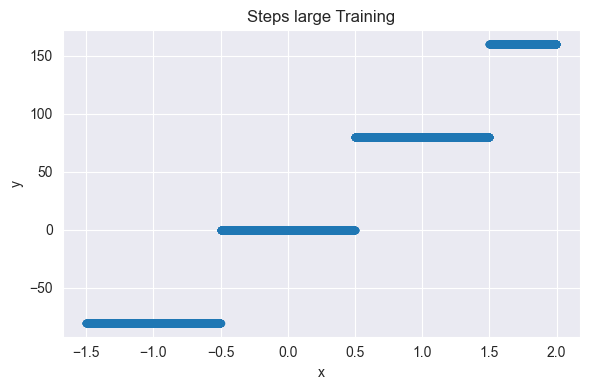

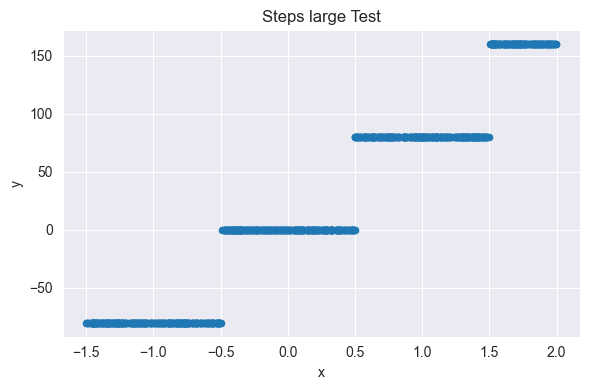

In [12]:
plot_xy_scatter(steps_large_training, title='Steps large Training')
plot_xy_scatter(steps_large_test, title='Steps large Test')

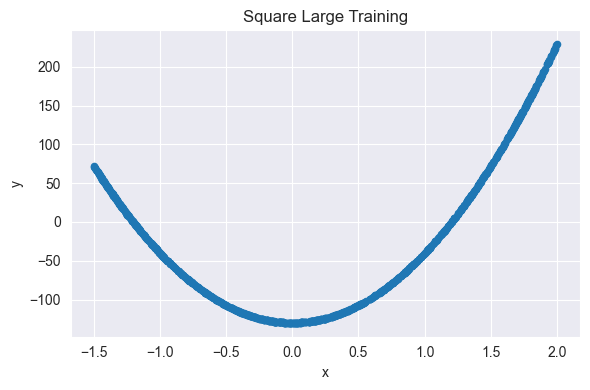

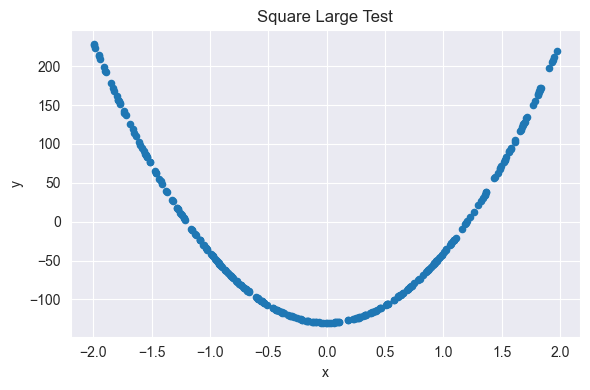

In [13]:
plot_xy_scatter(square_large_training, title='Square Large Training')
plot_xy_scatter(square_large_test , title='Square Large Test')

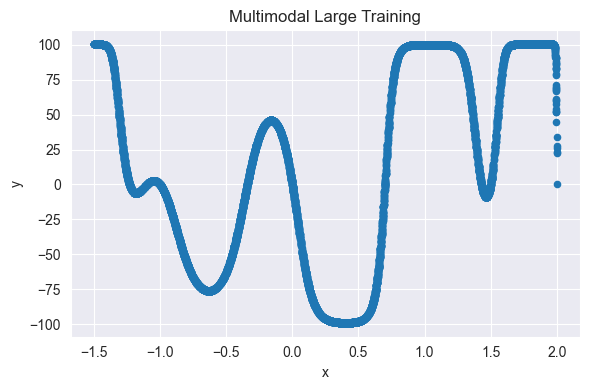

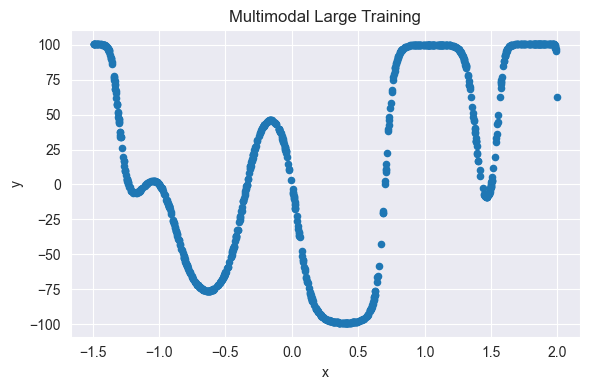

In [14]:
plot_xy_scatter(multimodal_large_training, title='Multimodal Large Training')
plot_xy_scatter(multimodal_large_test, title='Multimodal Large Training')


### ja najpierw learning_rate 0.05 potem 0.01 potem 0.005 potem 0.001 potem 0.0005 potem 0.0001 etc do skutku az loss bd elegancki

# steps_large


In [15]:
neural_network_0 = NeuralNetwork3(layer_sizes=[1,10,10,10,10,1],
                                  activation='relu',
                                  output_activation='linear',
                                  init_method='he')



neural_network_0.params = read_dict('data/NN3/weights_steps_large.txt')

x_train_scaled_0, y_train_scaled_0,  x_test_scaled_0, y_test_0, scaling_params_0 =  load_and_scale_data(steps_large_training,
                                                                                                        steps_large_test, 'x','y')


In [125]:
'''
neural_network_0.train(x_train_scaled_0, y_train_scaled_0, batch_size = 100 ,epochs = 1000, learning_rate=0.000005, verbose = 500, optimizer = 'adam')
'''

"\nneural_network_0.train(x_train_scaled_0, y_train_scaled_0, batch_size = 100 ,epochs = 1000, learning_rate=0.000005, verbose = 500, optimizer = 'adam')\n"

In [126]:
y_predict_0 = neural_network_0.forward(x_test_scaled_0)
y_test_mean_0 = scaling_params_0[2]
y_test_sd_0 = scaling_params_0[3]
y_predict_rescaled_0 = y_predict_0 * y_test_sd_0 + y_test_mean_0
neural_network_0.compute_loss(y_test_0, y_predict_rescaled_0)

np.float64(1.1671625482036343)

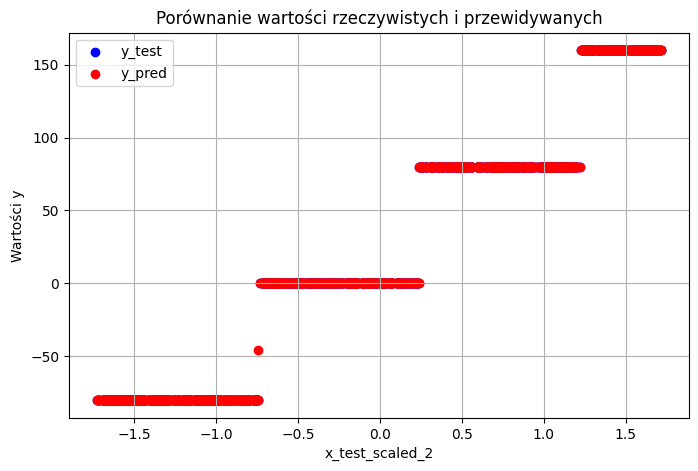

In [127]:
plot_results(x_test_scaled_0, y_test_0,  y_predict_rescaled_0)

## square large

In [128]:
neural_network_1 = NeuralNetwork3(layer_sizes=[1,20,1],
                                  activation='sigmoid',
                                  output_activation='linear',
                                  init_method='xavier')



neural_network_1.params = read_dict('data/NN3/weights_square_large.txt')

x_train_scaled_1, y_train_scaled_1,  x_test_scaled_1, y_test_1, scaling_params_1 =  load_and_scale_data(square_large_training,
                                                                                                        square_large_test, 'x','y')




In [129]:

#neural_network_1.train(x_train_scaled_1, y_train_scaled_1, batch_size = 100 ,epochs = 10000, learning_rate=0.00001, verbose = 500, optimizer = 'adam')


In [130]:
y_predict_1 = neural_network_1.forward(x_test_scaled_1)
y_test_mean_1 = scaling_params_1[2]
y_test_sd_1 = scaling_params_1[3]
y_predict_rescaled_1 = y_predict_1 * y_test_sd_1 + y_test_mean_1
neural_network_1.compute_loss(y_test_1, y_predict_rescaled_1)

np.float64(0.9974211322874141)

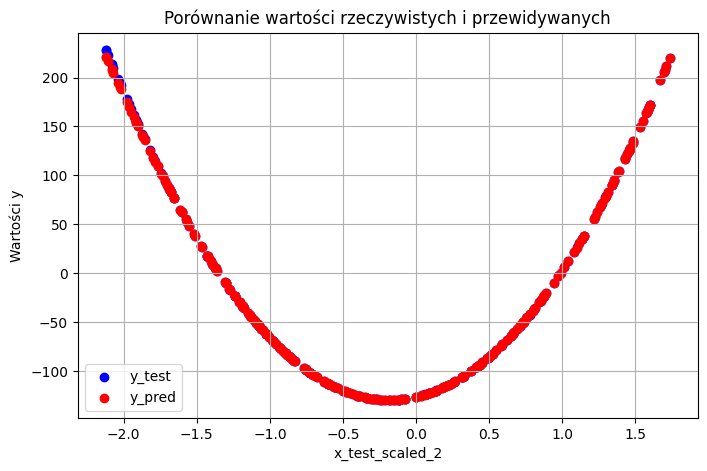

In [131]:
plot_results(x_test_scaled_1, y_test_1, y_predict_rescaled_1)

 # multimodal_large_training

In [132]:

neural_network_2 = NeuralNetwork3(layer_sizes=[1,16,16,16,1],
                                  activation='relu',
                                  output_activation='linear',
                                 init_method='he')



neural_network_2.params = read_dict('data/NN3/weights_multimodal_large.txt')
x_train_scaled_2, y_train_scaled_2, x_test_scaled_2, y_test_2, scaling_params_2 =  load_and_scale_data(multimodal_large_training, multimodal_large_test, 'x','y')



In [133]:
'''
neural_network_2.train(x_train_scaled_2, y_train_scaled_2, batch_size = 100 ,epochs = 10000, learning_rate=0.01,verbose=500,optimizer='RMSprop')
'''

"\nneural_network_2.train(x_train_scaled_2, y_train_scaled_2, batch_size = 100 ,epochs = 10000, learning_rate=0.01,verbose=500,optimizer='RMSprop')\n"

In [134]:
y_predict_2 = neural_network_2.forward(x_test_scaled_2)
y_test_mean_2 = scaling_params_2[2]
y_test_sd_2 = scaling_params_2[3]
y_predict_rescaled_2 = y_predict_2 * y_test_sd_2 + y_test_mean_2
neural_network_2.compute_loss(y_test_2, y_predict_rescaled_2)

np.float64(3.417058901667808)

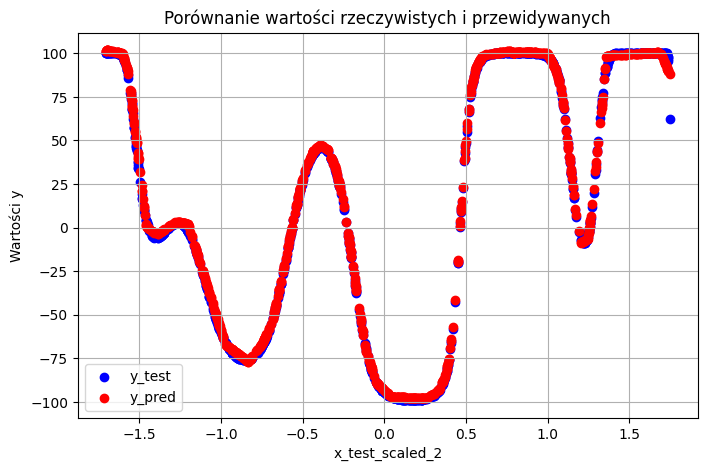

In [135]:
plot_results(x_test_scaled_2, y_test_2, y_predict_rescaled_2)

## batch / epoch analiza czasu



In [ ]:
neural_network_0 = NeuralNetwork3(layer_sizes=[1,10,10,10,10,1],
                                  activation='relu',
                                  output_activation='linear',
                                  init_method='he')



neural_network_0.params = read_dict('data/NN3/weights_steps_large.txt')

x_train_scaled_0, y_train_scaled_0,  x_test_scaled_0, y_test_0, scaling_params_0 =  load_and_scale_data(steps_large_training,
                                                                                                        steps_large_test, 'x','y')



--- Test dla 50 epok ---
Final Loss: 0.012202912325595776
Final Loss: 0.0062679765027484555
Final Loss: 0.032152732774830946
Final Loss: 0.0021670793652846577
Final Loss: 0.02082348198523027
Final Loss: 0.00726560226465391
Final Loss: 0.013331238665895018
Final Loss: 0.016730012669943013
Final Loss: 0.01084494376465357
Final Loss: 0.02518260619838277
Final Loss: 0.06559879167282778
Final Loss: 0.003971093420828584
Final Loss: 0.00743681290903765
Final Loss: 0.008800383531994417
Final Loss: 0.006417228048945813
Final Loss: 0.011058590402787458
Final Loss: 0.0053345290280194186
Final Loss: 0.0057137464523424235
Final Loss: 0.004007880318266884
Final Loss: 0.01010197311644462

--- Test dla 100 epok ---
Final Loss: 0.0038137607401894074
Final Loss: 0.0057743102584212
Final Loss: 0.0035061898004307536
Final Loss: 0.005261029965224432
Final Loss: 0.0072031038526021735
Final Loss: 0.0023834636553592605
Final Loss: 0.002484468028131255
Final Loss: 0.010084535895518564
Final Loss: 0.0061904926

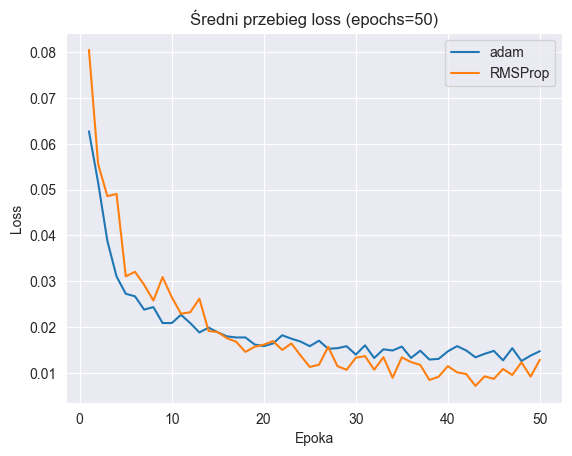

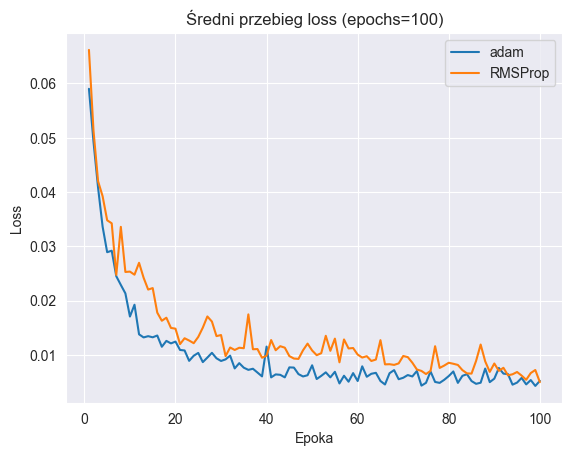

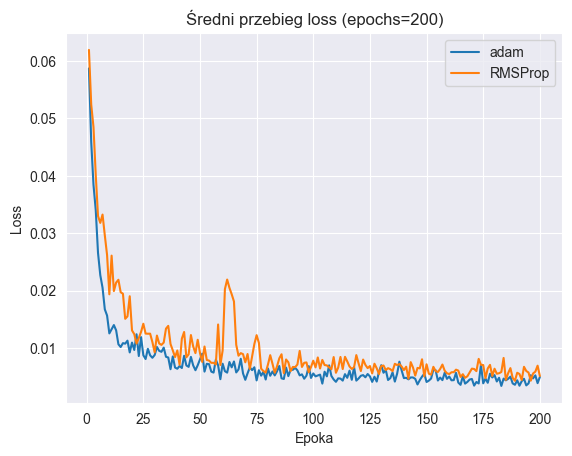

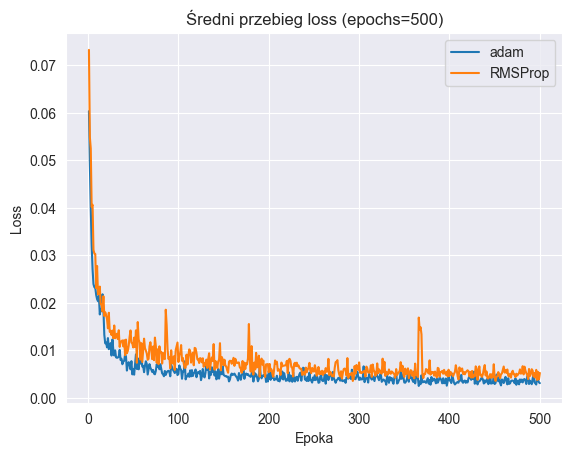

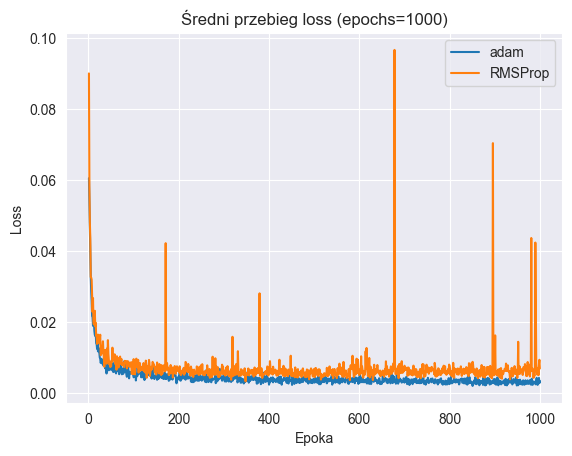

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Listy do konfiguracji
optimizers = ["adam", "RMSProp"]
epoch_settings = [50, 100, 200,500,1000]  # Zamiast 100, 1000, 10000
num_runs = 10

# Tabela końcowych średnich strat
# Wiersze: optimizers, kolumny: epoki
results_table = pd.DataFrame(index=optimizers,
                             columns=epoch_settings,
                             dtype=float)

# Aby móc narysować uśrednione przebiegi, przechowamy je w słowniku
# Struktura: avg_losses[optimizer][epoki] = [lista średnich strat w kolejnych epokach]
avg_losses = {opt: {} for opt in optimizers}

# Pętla po liczbie epok (4 warianty)
for epochs in epoch_settings:
    print(f"\n--- Test dla {epochs} epok ---")

    # Przygotowanie struktur do liczenia średnich przebiegów
    # (będziemy sumować 10 krzywych, potem dzielić przez 10)
    losses_accumulator = {
        "adam": np.zeros(epochs, dtype=float),
        "RMSProp": np.zeros(epochs, dtype=float)
    }

    # Pętla po optymalizatorach
    for opt in optimizers:
        final_losses = []  # tu zbierzemy ostatni loss z każdej próby (do tabelki)

        # 10 powtórzeń
        for run_idx in range(num_runs):
            # Za każdym razem tworzymy nowy obiekt sieci, aby resetować wagi
            nn_temp = NeuralNetwork3(
                layer_sizes=[1, 10,10,10,10, 1],
                activation='relu',
                output_activation='linear',
                init_method='he'
            )

            # Trening; zakładam, że train(...) zwraca listę strat z każdej epoki
            epoch_losses = nn_temp.train(
                x_train_scaled_0,
                y_train_scaled_0,
                batch_size=100,
                epochs=epochs,
                learning_rate=0.01,
                optimizer=opt,
                verbose=999999,    # ustawiłem duży, by nie spamować wydruku
                return_losses=True # chcemy mieć listę strat
            )

            # Dodajemy (punktowo) do akumulatora
            losses_accumulator[opt] += np.array(epoch_losses)
            # Zapamiętujemy finalny loss (ostatni z listy)
            final_losses.append(epoch_losses[-1])

        # Po 10 powtórzeniach liczymy średni finalny loss
        mean_final_loss = np.mean(final_losses)
        # Wpisujemy do tabeli
        results_table.loc[opt, epochs] = mean_final_loss

    # Teraz obliczamy rzeczywiste średnie przebiegi w każdej epoce
    # (dzielimy sumę przez liczbę powtórzeń)
    for opt in optimizers:
        avg_loss_array = losses_accumulator[opt] / num_runs
        # Zapisujemy do słownika, by móc narysować wykres
        avg_losses[opt][epochs] = avg_loss_array

# WYPISUJEMY TABELĘ Z FINALNYMI STRATAMI
print("\nTABELA ŚREDNICH FINALNYCH STRAT (po ostatniej epoce):")
print(results_table)

# Rysujemy wykresy - osobny dla każdej z 4 wartości epok.
for epochs in epoch_settings:
    plt.figure()
    plt.title(f"Średni przebieg loss (epochs={epochs})")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")

    # Dla każdego z dwóch optymalizatorów rysujemy krzywą
    for opt in optimizers:
        plt.plot(
            range(1, epochs+1),
            avg_losses[opt][epochs],
            label=f"{opt}"
        )
    plt.legend()
    plt.show()
